In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
from matplotlib import cm

import seaborn as sns

from tqdm.auto import tqdm

import os
import ctypes
import gc

In [2]:
dirname = '../src/model_ctypes/_koivumaki/'
filename_so = os.path.join(dirname, 'koivumaki.so')

filename_so_abs = os.path.abspath(filename_so)

model = ctypes.CDLL(filename_so_abs)

model.initialize_states_default.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]

model.initialize_states_default.restype = ctypes.c_void_p


model.run.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS')
]

model.run.restype = ctypes.c_int


model.run_algebraic.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'), # double *S
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'), # double *C
    ctypes.c_int, # int n_beats
    ctypes.c_double, # double t_sampling
    ctypes.c_double, # double tol
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS'), # double *output
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS'), # double *output_A
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS') # double *output_t
]

model.run_algebraic.restype = ctypes.c_int


legend_constants = pd.read_csv(os.path.join(dirname, "legend_constants.csv"), index_col='name')['value']
legend_states = pd.read_csv(os.path.join(dirname, "legend_states.csv"), index_col='name')['value']
legend_algebraic = pd.read_csv(os.path.join(dirname, "legend_algebraic.csv"), index_col='name')
legend_algebraic['value'] = 0

model.initialize_states_default(legend_states.values, legend_constants.values)

4621082499826719547

In [3]:
S = legend_states.copy()
C = legend_constants.copy()
A = legend_algebraic.copy()

In [139]:
C['Jrel_multiplier'] = 10#1
C['fluo_tot'] = 0.01

model.initialize_states_default(S.values, C.values)

4621082499826719547

In [4]:
t_sampling = 0.001

C['STIM_PERIOD'] = 1
stim_period = C['STIM_PERIOD']
n_samples_per_stim = int(stim_period / t_sampling)

n_beats = 1000
tol = 1e-6

output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
output_A = np.zeros((n_samples_per_stim * n_beats + 1, len(A)))
t = np.zeros(n_samples_per_stim * n_beats + 1)

In [141]:
# status = model.run(S.values.copy(), C.values.copy(),
#                    n_beats, t_sampling, tol, output)

# print(status)

In [142]:
status = model.run_algebraic(S.values.copy(), C.values.copy(),
                             n_beats, t_sampling, tol, output,
                             output_A, t)

print(status)

2


In [143]:
output = pd.DataFrame(output, columns=legend_states.index)
output_A = pd.DataFrame(output_A, columns=legend_algebraic.index)

In [144]:
volumes = legend_constants[['Vss'] + [f'Vnonjunct{i}' for i in range(1, 4 + 1)]]

concentrations = output[['Cass'] + [f'Cai{i}' for i in range(1, 4 + 1)]]
Cai_mean = (concentrations.values * volumes.values).sum(axis=1) / sum(volumes)

concentrations = output[['fluo_ss'] + [f'fluo_{i}' for i in range(1, 4 + 1)]]
fluo_mean = (concentrations.values * volumes.values).sum(axis=1) / sum(volumes)

output['Cai_mean'] = Cai_mean
output['fluo_mean'] = fluo_mean

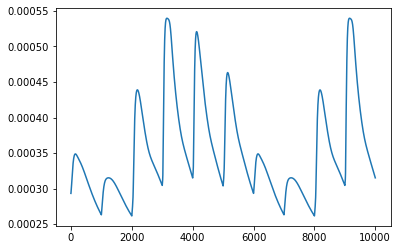

In [145]:
plt.plot(Cai_mean[-10000:])

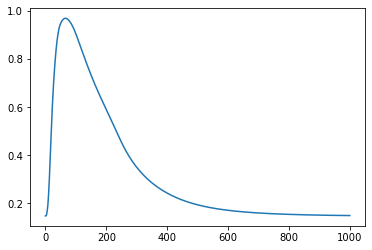

In [11]:
plt.plot(Cai_mean[:1000] * 1000)

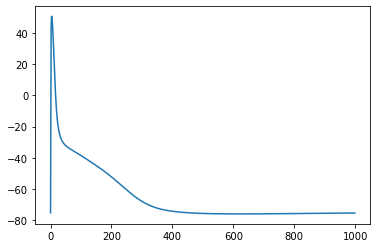

In [12]:
plt.plot(output.V[:1000])

In [82]:
CL_list = [2000, 1000, 500]

dirname = "../data/koivumaki/fluo"

for CL in tqdm(CL_list):
    
    break
    
    t_sampling = 0.001
    
    C['STIM_PERIOD'] = CL / 1000
    stim_period = C['STIM_PERIOD']
    n_samples_per_stim = int(stim_period / t_sampling)

    n_beats = int(1000 * 1000 / CL)
    tol = 1e-6

    output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
    output_A = np.zeros((n_samples_per_stim * n_beats + 1, len(A)))
    t = np.zeros(n_samples_per_stim * n_beats + 1)
    
    status = model.run_algebraic(S.values.copy(), C.values.copy(),
                             n_beats, t_sampling, tol, output,
                             output_A, t)

    print(status)
    
    output = pd.DataFrame(output, columns=legend_states.index)
    output_A = pd.DataFrame(output_A, columns=legend_algebraic.index)
    
    phenotype = output[-CL - 1:]
    state = phenotype.iloc[-1].values
    
    phenotype.to_csv(os.path.join(dirname, 'phenotypes', f'phenotype_{CL}.csv'), index=False)
    np.savetxt(os.path.join(dirname, 'states', f'state_{CL}.txt'), state)

  0%|          | 0/3 [00:00<?, ?it/s]

In [32]:
states = {}

for CL in CL_list:
    phenotype = pd.read_csv(os.path.join(dirname, 'phenotypes', f'phenotype_{CL}.csv'))
    states[CL] = phenotype.iloc[-1]
    
states = pd.concat(states, axis=1).T

In [ ]:
plt.plot(output.Cai_mean) 

In [9]:
df = output[-1001:].reset_index()

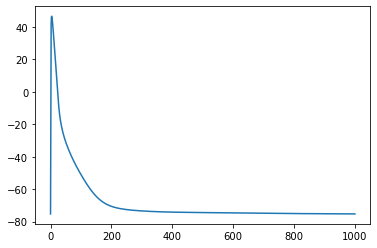

In [10]:
plt.plot(df.V)

[[<matplotlib.lines.Line2D at 0x7f74ba39ed60>],

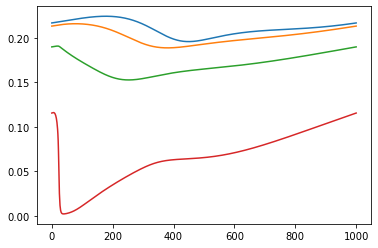

In [11]:
[plt.plot(df[f'CaSR{i}']) for i in range(1, 4+1)]

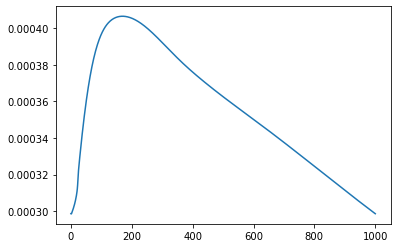

In [12]:
plt.plot(df.Cai_mean)

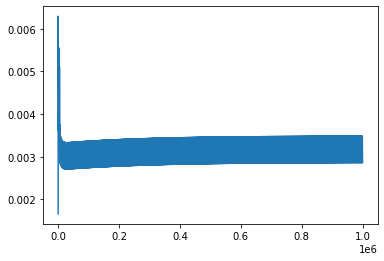

In [13]:
plt.plot(output.fluo_mean)

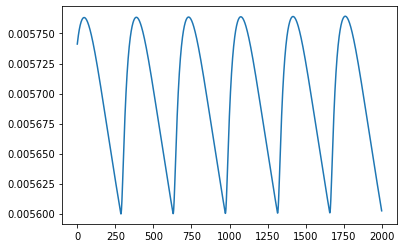

In [43]:
plt.plot(output.fluo_mean[-2000:].values)

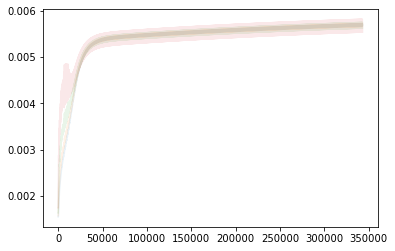

In [44]:
for i in range(1, 4+1):
    plt.plot(output[f'fluo_{i}'], alpha=0.1)

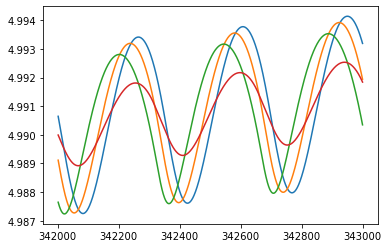

In [46]:
for i in range(1, 4+1):
    plt.plot(output[f'CaSR{i}'][-1000:])

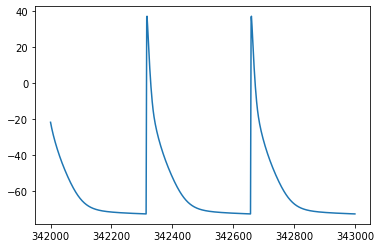

In [47]:
plt.plot(output.V[-1001:])

In [18]:
rescale = lambda x: (x - np.min(x)) / np.ptp(x)

Text(0, 0.5, 'normalized units')

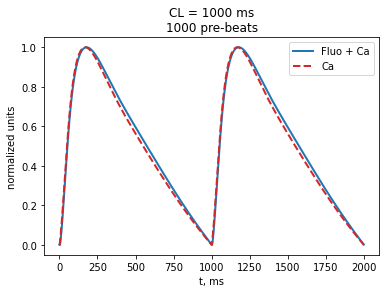

In [19]:
plt.plot(rescale(df.fluo_mean), lw=2, label='Fluo + Ca')
plt.plot(rescale(df.Cai_mean), '--', color='C3', lw=2, label='Ca')

plt.legend()
plt.title('CL = 1000 ms\n1000 pre-beats')
plt.xlabel('t, ms')
plt.ylabel('normalized units')

#plt.savefig("../images/fluo/fluo_ca_shapes.png", dpi=300, facecolor='white')

In [20]:
df[['Cai_mean', 'fluo_mean']].describe().iloc[1:]

name,Cai_mean,fluo_mean
mean,0.000422,0.003618
std,0.000023,0.000125
min,0.000383,0.003410
25%,0.000400,0.003506
50%,0.000421,0.003618
75%,0.000443,0.003732
max,0.000458,0.003806


In [27]:
def Ca(F, F_max=0.01, F_min=0, Kd=0.74e-3): # Kd=0.74e-3
    return Kd * (F - F_min) / (F_max - F)

In [28]:
ca = Ca(df.fluo_mean)

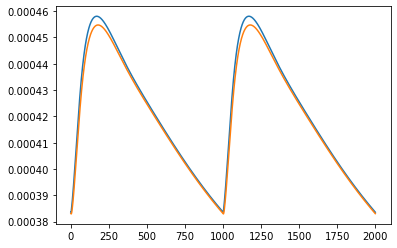

In [29]:
plt.plot(df.Cai_mean)
plt.plot(Ca(df.fluo_mean))

In [82]:
rel_range = np.logspace(-2, 2, 13)# [0.1, 1, 10, 100]

In [5]:
fluo_tot_range = np.hstack([0, np.logspace(-3, 0, 13)])

In [6]:
# columns = 'Cai_mean', 'fluo_mean', 'fluo_rel', 'V'

result = []
result_A = []

# fig, axes = plt.subplots(nrows=len(columns), figsize=plt.figaspect(3), sharex=True)

#fluo_tot_range = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.]

for i, fluo_tot in tqdm(list(enumerate(fluo_tot_range))):
#for i, rel in tqdm(enumerate(rel_range)):
    
    C['fluo_tot'] = fluo_tot
    #C['Jrel_multiplier'] = rel
    #C['J_SERCASR_multiplier'] = rel

    
    model.initialize_states_default(S.values, C.values)
    
    C['STIM_PERIOD'] = 1
    stim_period = C['STIM_PERIOD']
    n_samples_per_stim = int(stim_period / t_sampling)

    n_beats = 1000

    output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
    output_A = np.zeros((n_samples_per_stim * n_beats + 1, len(A)))
    t = np.zeros(n_samples_per_stim * n_beats + 1)
    
    status = model.run_algebraic(S.values.copy(), C.values.copy(),
                                 n_beats, t_sampling, tol, output,
                                 output_A, t)
    output = output[-1011:]
    output = pd.DataFrame(output, columns=legend_states.index)
    
    output_A = output_A[-1011:]
    output_A = pd.DataFrame(output_A, columns=legend_algebraic.index)
    
    volumes = legend_constants[['Vss'] + [f'Vnonjunct{i}' for i in range(1, 4 + 1)]]

    concentrations = output[['Cass'] + [f'Cai{i}' for i in range(1, 4 + 1)]]
    Cai_mean = (concentrations.values * volumes.values).sum(axis=1) / sum(volumes)

    concentrations = output[['fluo_ss'] + [f'fluo_{i}' for i in range(1, 4 + 1)]]
    fluo_mean = (concentrations.values * volumes.values).sum(axis=1) / sum(volumes)

    output['Cai_mean'] = Cai_mean
    output['fluo_mean'] = fluo_mean
    #output['fluo_rel'] = fluo_mean / fluo_tot * 100
        
    result.append(output.copy())
    result_A.append(output_A.copy())
    
    del output
    del output_A
    gc.collect()

  0%|          | 0/14 [00:00<?, ?it/s]

In [119]:
rel_range[8]

4.6415888336127775

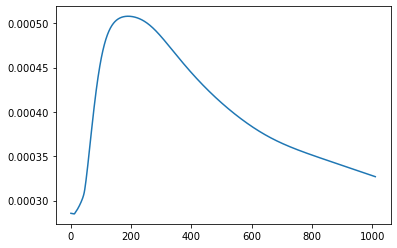

In [120]:
plt.plot(result[8].Cai_mean)

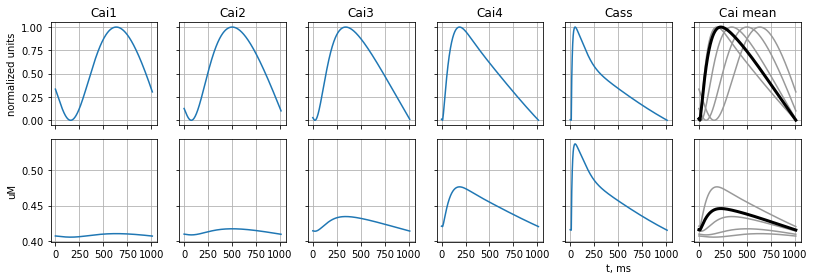

In [82]:
fig, axes = plt.subplots(ncols=6, nrows=2,
                         figsize=plt.figaspect(0.35),
                         sharex=True, sharey='row')

#axes = axes.flatten()

df = result[6]


for i in range(2):
    
    if i == 1:
        rescale = lambda x: x * 1000
    else:
        rescale = lambda x: (x - np.min(x)) / np.ptp(x)

    for j in range(1, 4+1):
        ax = axes[i][j-1]
        key = f'Cai{j}'
        ax.plot(rescale(df[key]))
        axes[i][-1].plot(rescale(df[key]), color='0.6')
        if i == 0:
            ax.set_title(key)

    axes[i][-1].plot(rescale(df.Cai_mean), lw=3, color='k')
    axes[i][-2].plot(rescale(df['Cass']))

    if i == 0:
        axes[i][-1].set_title('Cai mean')
        axes[i][-2].set_title('Cass')
    else:
        axes[i][-2].set_xlabel('t, ms')

    for ax in axes.flatten():
        ax.grid(True)
        ax.set_xticks(np.linspace(0, 1000, 5))
        
axes[0, 0].set_ylabel('normalized units')
axes[1, 0].set_ylabel('uM')

plt.tight_layout()

plt.savefig("../images/fluo/compartments.png", dpi=600)

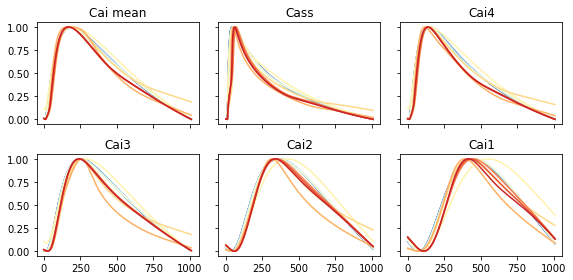

In [103]:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         figsize=plt.figaspect(0.5),
                         sharex=True,
                         sharey=True)

axes = axes.flatten()

cmap = cm.coolwarm
cmap = cm.RdYlBu_r

for i, df in enumerate(result):
    
    rescale = lambda x: (x - np.min(x)) / np.ptp(x)
    #rescale = lambda x: x * 1000
    
    color = cmap(i/len(result))
    
    axes[0].plot(rescale(df.Cai_mean), color=color)
    #axes[0].plot(df.Cai_mean)
    
    axes[1].plot(rescale(df['Cass']), color=color)
    
    for j in range(1, 4+1):
        ax = axes[1+j]
        key = f'Cai{5-j}'
        ax.plot(rescale(df[key]), color=color)
        ax.set_title(key)
        
axes[0].set_title('Cai mean')
axes[1].set_title('Cass')

plt.tight_layout()

plt.savefig("../images/fluo/rel_variation_normalized.png", dpi=600)

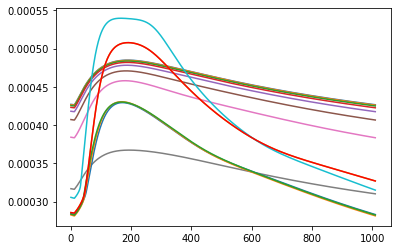

In [117]:
for i, df in enumerate(result):
    plt.plot(df.Cai_mean)
    
plt.plot(result[8].Cai_mean, 'r')

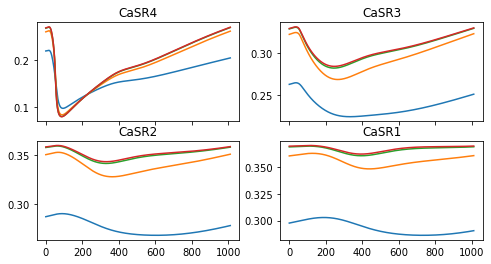

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=plt.figaspect(0.5), sharex=True)

axes = axes.flatten()

for i, df in enumerate(result):
    
    rescale = lambda x: (x - np.min(x)) / np.ptp(x)
    
    for j in range(1, 4+1):
        ax = axes[j-1]
        key = f'CaSR{5-j}'
        ax.plot(df[key])
        #ax.plot(rescale(df[key]))
        ax.set_title(key)

([<matplotlib.axis.XTick at 0x7f7e84b59940>,
 [Text(0, 0, '0.1'), Text(1, 0, '1'), Text(2, 0, '10'), Text(3, 0, '100')])

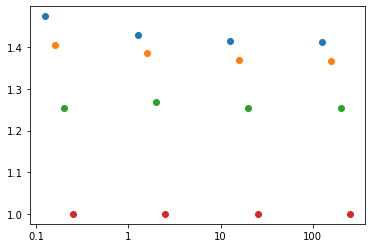

In [55]:
for i, df in enumerate(result):
    for j in range(1, 4+1):
        key = f'CaSR{j}'
        y = df[key].iloc[-1] / df[f'CaSR4'].iloc[-1]
        plt.plot(i+0.1*j, y, 'o', color=f'C{j-1}')
        #ax.plot(rescale(df[key]))
        #ax.set_title(key)
        
plt.xticks(range(len(rel_range)), rel_range)

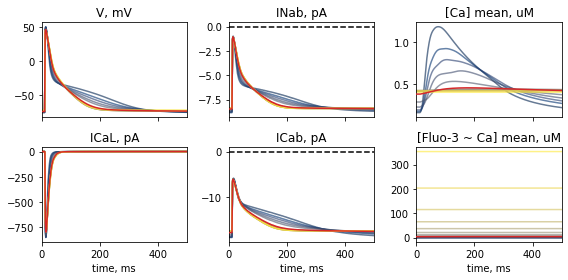

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=plt.figaspect(0.5), sharex=True)

cmap = cm.cividis

for i, df in enumerate(result):

    color = cmap(i / (len(result) - 1))
    
    kw = dict(color=color, alpha=0.6, zorder=0) if i != 5 else dict(color='C3', alpha=1, zorder=10)
    
    axes[0, 0].plot(df.V, **kw)
    axes[0, 2].plot(1e3 * df.Cai_mean, **kw)
    axes[1, 2].plot(1e3 * df.fluo_mean, **kw)
    
for i, df in enumerate(result_A):

    color = cmap(i / (len(result_A) - 1))
    
    kw = dict(color=color, alpha=0.6, zorder=0) if i != 5 else dict(color='C3', alpha=1, zorder=10)

    axes[1, 0].plot(df.I_ICaL, **kw)
    axes[0, 1].plot(df.I_INab, **kw)
    axes[1, 1].plot(df.I_ICab, **kw)
    
axes[0, 1].axhline(0, ls='--', color='k')
axes[1, 1].axhline(0, ls='--', color='k')

titles = [['V, mV', 'INab, pA', '[Ca] mean, uM'],
          ['ICaL, pA', 'ICab, pA', '[Fluo-3 ~ Ca] mean, uM']]

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        ax.set_title(titles[i][j])
        if i:
            ax.set_xlabel('time, ms')
        
    
plt.xlim(0, 500)

plt.tight_layout()

# plt.savefig("../images/fluo/koivumaki_slides_2.png", dpi=600)

In [10]:
result[0].fluo_mean *= 0

In [11]:
result_short = [result[0], result[1], result[5], result[9]]
fluo_short = [fluo_tot_range[0], fluo_tot_range[1], fluo_tot_range[5], fluo_tot_range[9]]

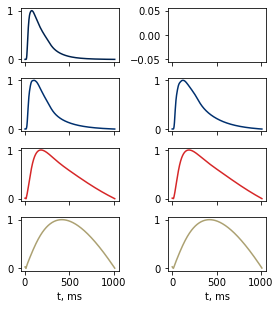

In [12]:
indices = [0, 1, 5, 9]

cmap = cm.cividis

fig, axes = plt.subplots(nrows=len(indices), ncols=2,
                         figsize=plt.figaspect(1.1), sharex=True)

rescale = lambda x: (x - np.min(x)) / np.ptp(x)
#rescale = lambda x: x * 1000

for i_ax, i in enumerate(indices): # , (a, fluo) in enumerate(zip(result_short, fluo_short)):
    
    a = result[i].copy()
    fluo = fluo_tot_range[i]
    
    #kw = dict(color=color, alpha=0.6, zorder=0) if i != 5 else dict(color='C3', alpha=1, zorder=10)
    
    color = cmap(i / (len(result_A) - 1))

#     axes[i_ax, 0].plot(1e3 * a.Cai_mean, color=color if i_ax != 2 else 'C3')
#     axes[i_ax, 1].plot(1e3 * a.fluo_mean, color=color if i_ax != 2 else 'C3')
    
    axes[i_ax, 0].plot(rescale(a.Cai_mean), color=color if i_ax != 2 else 'C3')
    axes[i_ax, 1].plot(rescale(a.fluo_mean), color=color if i_ax != 2 else 'C3')
    
#     axes[i_ax, 1].set_title("[Fluo-3] = {} uM{}".format(int(fluo * 1e3), "\n(Vanessa)" if i_ax == 2 else ""), size='x-small')
    
# axes[0, 0].set_title('[Ca] mean, uM')
# axes[0, 1].set_title('[Fluo-3 ~ Ca] mean, uM')

for i in range(2):
    axes[-1, i].set_xlabel('t, ms')
    
plt.tight_layout()

#plt.savefig("../images/fluo/koivumaki_ca_fluo.png", dpi=600, bbox_inches='tight')

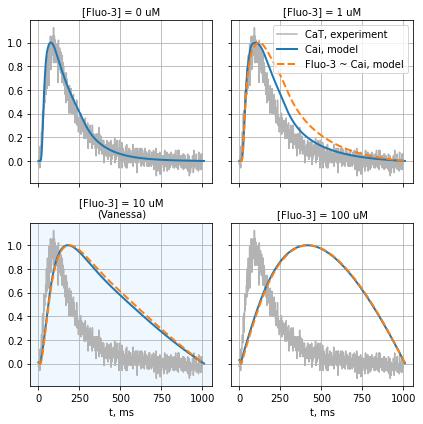

In [52]:
indices = [0, 1, 5, 9]

cmap = cm.cividis

fig, axes = plt.subplots(ncols=2, nrows=2, # len(indices)
                         figsize=(6, 6),
                         sharex=True, sharey=True)

axes = axes.flatten()

cat_voigt = pd.read_csv("../misc/cat_voigt_1_2.csv").iloc[:, 0]

rescale = lambda x: (x - np.min(x)) / np.ptp(x)

for i_ax, i in enumerate(indices):
    
    ax = axes[i_ax]
    
    a = result[i].copy()
    fluo = fluo_tot_range[i]
        
    color = cmap(i / (len(result_A) - 1))

    ax.plot(rescale(cat_voigt)*1.25 - 0.125, color='0.7', label='CaT, experiment')
    
    ax.plot(rescale(a.Cai_mean), color='C0', label='Cai, model', lw=2)
    ax.plot(rescale(a.fluo_mean), '--', color='C1', label='Fluo-3 ~ Cai, model', lw=2)
    
    if i_ax == 1:
        ax.legend()
        
    if i_ax == 2:
        ax.set_facecolor('aliceblue')
    
    ax.set_title("[Fluo-3] = {} uM{}".format(int(fluo * 1e3), "\n(Vanessa)" if i_ax == 2 else ""), size='medium')
    
# axes[0, 0].set_title('[Ca] mean, uM')
# axes[0, 1].set_title('[Fluo-3 ~ Ca] mean, uM')

    if i_ax >= 2:
        ax.set_xlabel('t, ms')
    
for ax in axes.flatten():
    ax.set_xticks(np.linspace(0, 1000, 5))
    ax.grid()
    
plt.tight_layout()

plt.savefig("../images/fluo/koivumaki_ca_fluo.png", dpi=600, bbox_inches='tight')

In [70]:
df = result[5]

In [71]:
df

name,CaSR1,CaSR2,CaSR3,CaSR4,Cai1,Cai2,Cai3,Cai4,Cass,d,...,serca_ass,Nai,Nass,fluo_1,fluo_2,fluo_3,fluo_4,fluo_ss,Cai_mean,fluo_mean
0,2.020198,2.016409,2.008904,1.996886,0.000378,0.000380,0.000383,0.000388,0.000382,0.000012,...,0.022575,11.082181,11.099273,0.003375,0.003387,0.003408,0.003437,0.003404,0.000384,0.003415
1,2.020216,2.016434,2.008942,1.996950,0.000378,0.000380,0.000383,0.000388,0.000382,0.000012,...,0.022575,11.082181,11.098827,0.003375,0.003386,0.003407,0.003436,0.003404,0.000384,0.003414
2,2.020235,2.016458,2.008980,1.997015,0.000378,0.000380,0.000383,0.000388,0.000382,0.000012,...,0.022576,11.082181,11.098382,0.003375,0.003386,0.003407,0.003436,0.003403,0.000384,0.003414
3,2.020253,2.016483,2.009018,1.997079,0.000378,0.000379,0.000383,0.000388,0.000382,0.000012,...,0.022576,11.082181,11.097936,0.003375,0.003386,0.003407,0.003435,0.003402,0.000384,0.003413
4,2.020272,2.016507,2.009056,1.997143,0.000378,0.000379,0.000383,0.000388,0.000382,0.000012,...,0.022576,11.082182,11.097489,0.003374,0.003386,0.003406,0.003435,0.003402,0.000384,0.003413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,2.020302,2.016549,2.009124,1.997263,0.000377,0.000379,0.000383,0.000387,0.000382,0.000012,...,0.022576,11.082380,11.096724,0.003374,0.003385,0.003406,0.003434,0.003401,0.000384,0.003412
1007,2.020320,2.016573,2.009162,1.997327,0.000377,0.000379,0.000383,0.000387,0.000382,0.000012,...,0.022576,11.082380,11.096277,0.003374,0.003385,0.003405,0.003433,0.003400,0.000384,0.003412
1008,2.020338,2.016597,2.009199,1.997390,0.000377,0.000379,0.000383,0.000387,0.000382,0.000012,...,0.022576,11.082380,11.095830,0.003374,0.003385,0.003405,0.003433,0.003400,0.000384,0.003411
1009,2.020357,2.016621,2.009237,1.997454,0.000377,0.000379,0.000383,0.000387,0.000381,0.000012,...,0.022576,11.082380,11.095383,0.003374,0.003385,0.003405,0.003432,0.003399,0.000384,0.003411


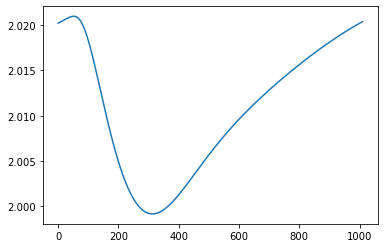

In [72]:
plt.plot(result[5].CaSR1)

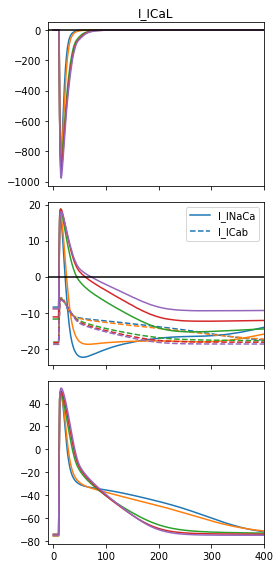

In [137]:
#columns = 'I_ICaL', 'I_INaCa', 'I_ICaP', 'I_ICab'

fig, axes = plt.subplots(nrows=3, figsize=plt.figaspect(2), sharex=True)

plt.sca(axes[0])

for a in result_A:
    plt.plot(a['I_ICaL'])

plt.axhline(0, color='k')
plt.title('I_ICaL')

plt.sca(axes[1])
    
for i, a in enumerate(result_A):
    for j, c in enumerate(['I_INaCa', 'I_ICab']): 
        plt.plot(a[c], ['-', '--'][j], color=f'C{i}', label=c)
    if i == 0:
        plt.legend()
#plt.legend()    
plt.axhline(0, color='k')
    
plt.sca(axes[2])
    
for a in result:
    plt.plot(a['V'])
    
plt.xlim(-10, 400)

fig.align_labels()
plt.tight_layout()

plt.savefig("../images/fluo/koivumaki_currents.png", dpi=600)
plt.show()